## Set paths

In [1]:
data_path = "/kaggle/input/emotions-450k/combined_df.csv"
enc_path = "/kaggle/input/emotions-450k/combined.npy"

## Imports

In [2]:
!pip install gritlm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 33.4 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: polars
    Found existing i

In [3]:
import csv
import tqdm
import torch
import random
import numpy as np
from gritlm import GritLM

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset
import copy
import matplotlib.pyplot as plt
import torch.nn.functional as F

## Load data

In [4]:
data = []  # list of (text, label)
with open(data_path, newline='') as csvfile:
    reader = csv.reader(csvfile)
    for i, row in enumerate(reader):
        if i == 0:  # skip csv header
            continue
        data.append((row[1], row[0]))

data_class = [int(d[0]) for d in data]

X = np.load(enc_path)

print(X.shape)

(456820, 4096)


## Create a train / val / test split

In [5]:
# make things reproducible
rng = np.random.default_rng(seed=0)

# shuffle the data
permuted = rng.permutation(len(X))
shuffled_x, shuffled_class = X[permuted], np.array(data_class)[permuted]


# create a train / test split
train_prop = 0.95
val_prop = 0.025
n_train = int(len(shuffled_x) * train_prop)
n_val = int(len(shuffled_x) * val_prop)
train_x, train_y = shuffled_x[:n_train], shuffled_class[:n_train]
validation_x, validation_y = shuffled_x[n_train:n_train+n_val], shuffled_class[n_train:n_train+n_val]
test_x, test_y = shuffled_x[n_train+n_val:], shuffled_class[n_train+n_val:]

# summary
print(f"Train set : {len(train_x)} samples")
print(f"Val set  : {len(validation_x)} samples")
print(f"Test set  : {len(test_x)} samples")

Train set : 433979 samples
Val set  : 11420 samples
Test set  : 11421 samples


## Train a classifier and compute the test accuracy

In [6]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report


# # Instantiate the random forest classifier
# clf = RandomForestClassifier(random_state=0, n_estimators=100)

# # Fit the model on the training data
# clf.fit(train_x, train_y)

# # Predict on the test set
# predictions = clf.predict(test_x)

# # Generate a classification report
# report = classification_report(test_y, predictions)
# print("Classification Report:\n", report)


## FFN

Training Accuracy: 0.7641
Validation Accuracy: 0.7782
Training Accuracy: 0.8112
Validation Accuracy: 0.8140
Training Accuracy: 0.8219
Validation Accuracy: 0.8257
Training Accuracy: 0.8403
Validation Accuracy: 0.8370
Training Accuracy: 0.8543
Validation Accuracy: 0.8486
Training Accuracy: 0.8594
Validation Accuracy: 0.8446
Training Accuracy: 0.8734
Validation Accuracy: 0.8520
Training Accuracy: 0.8836
Validation Accuracy: 0.8567
Training Accuracy: 0.8551
Validation Accuracy: 0.8360
Training Accuracy: 0.8965
Validation Accuracy: 0.8605
Training Accuracy: 0.9029
Validation Accuracy: 0.8636
Training Accuracy: 0.8840
Validation Accuracy: 0.8480


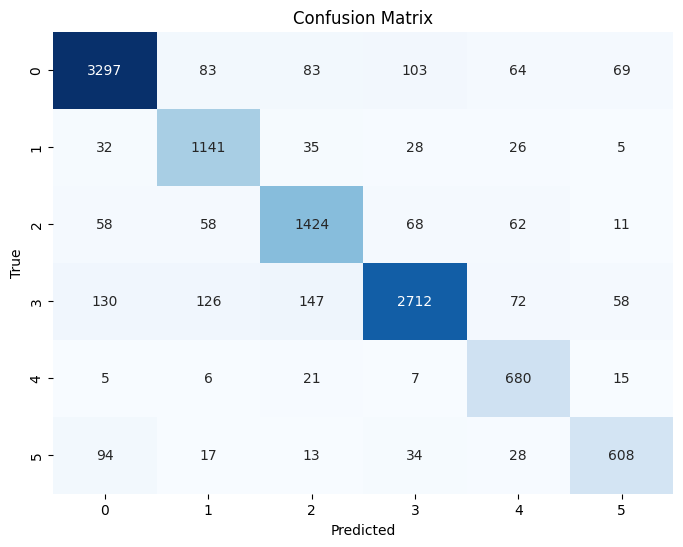

Final Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.89      0.90      3699
         1.0       0.80      0.90      0.85      1267
         2.0       0.83      0.85      0.84      1681
         3.0       0.92      0.84      0.88      3245
         4.0       0.73      0.93      0.82       734
         5.0       0.79      0.77      0.78       794

    accuracy                           0.86     11420
   macro avg       0.83      0.86      0.84     11420
weighted avg       0.87      0.86      0.86     11420



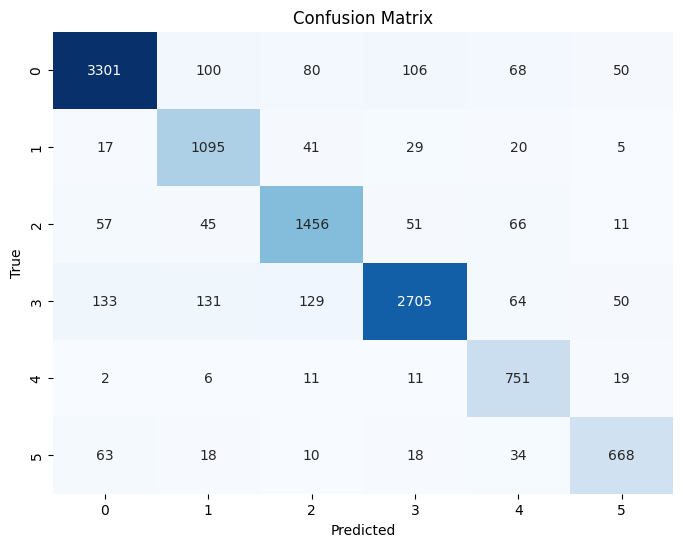

Final Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.89      0.91      3705
         1.0       0.78      0.91      0.84      1207
         2.0       0.84      0.86      0.85      1686
         3.0       0.93      0.84      0.88      3212
         4.0       0.75      0.94      0.83       800
         5.0       0.83      0.82      0.83       811

    accuracy                           0.87     11421
   macro avg       0.84      0.88      0.86     11421
weighted avg       0.88      0.87      0.87     11421



In [7]:
device = torch.device("cuda")

# Convert data to PyTorch tensors if they are not already
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
validation_x = torch.tensor(validation_x, dtype=torch.float32)
validation_y = torch.tensor(validation_y, dtype=torch.float32)
test_x = torch.tensor(test_x, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)




def calculate_class_weights(labels):
    unique_classes, class_counts = np.unique(labels, return_counts=True)
    total_samples = len(labels)
    num_classes = len(unique_classes)

    class_weights = []
    for i, class_label in enumerate(unique_classes):
        class_weight = total_samples / (num_classes * class_counts[i])
        class_weights.append(class_weight)

    return class_weights




# Define the FFN model
class CustomModule(nn.Module):
    def __init__(self, input_size, output_size):
        super(CustomModule, self).__init__()
        layers = [
            nn.Linear(input_size, output_size),
            nn.LayerNorm(output_size),
            nn.GELU(),
            nn.Dropout(0.25),
        ]
        
        self.module = nn.Sequential(*layers)

    def forward(self, x):
        return self.module(x)

class Backbone(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_experts):
        super(Backbone, self).__init__()
        
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.num_experts = num_experts

        self.drop_input = nn.Dropout(0.01)

        self.input_layer = CustomModule(self.input_size, self.hidden_sizes[0])
        self.layers, self.gates = self._build_layers()

    def _build_layers(self):
        layers = []
        gates = []

        for i in range(len(self.hidden_sizes) - 1):
            layers.append(nn.Sequential(*[CustomModule(self.hidden_sizes[i], self.hidden_sizes[i + 1]) for _ in range(self.num_experts)]))
            if self.num_experts > 1:
                gates.append(nn.Sequential(
                    nn.Linear(self.hidden_sizes[i], self.num_experts),
                    nn.Softmax(dim=1)
                ))

        layers = nn.Sequential(*layers)
        if self.num_experts > 1:
            gates = nn.Sequential(*gates)
        else:
            gates = None

        return layers, gates

    def forward(self, x):
        x = self.drop_input(x)
        x = self.input_layer(x)
        if self.num_experts > 1:
            for gate, layer in zip(self.gates, self.layers):
                expert_weights = gate(x).permute(1, 0)
                expert_outputs = [layer[i](x) for i in range(self.num_experts)]
                x = sum(expert_weight.unsqueeze(1) * expert_output for expert_weight, expert_output in zip(expert_weights, expert_outputs))
        else:
            for layer in (self.layers):
                x = layer[0](x)
            
        return x
        

class FFN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, num_experts=12):
        super(FFN, self).__init__()
        self.backbone = Backbone(input_size, hidden_sizes, num_experts)
        
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_sizes[-1], output_size),
        )
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.output_layer(x)
        return x

    
# Example usage:
input_size = len(train_x[0])
hidden_sizes = [8192, 256, 32]
output_size = 6

num_epochs = 12
batch_size = 1024
lr=1e-4
clf = FFN(input_size, hidden_sizes, output_size)
best_clf = FFN(input_size, hidden_sizes, output_size)


# Load
# checkpoint = torch.load("/kaggle/working/model_V1.pth", map_location="cuda")
# clf.load_state_dict(checkpoint)
# del checkpoint




# Loss function for multi-label classification with weighted cross-entropy
weights = torch.tensor(calculate_class_weights(train_y), dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.2)
# criterion = nn.CrossEntropyLoss()

# Optimizer (AdamW)
optimizer = optim.AdamW(clf.parameters(), lr=lr, weight_decay=2)

# Learning rate scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)




# Convert data to PyTorch DataLoader
class CustomDataset(Dataset):
    def __init__(self, data, labels, noise_factor, std_dev):
        self.data = data
        self.labels = labels
        self.noise_factor = noise_factor
        self.std_dev = std_dev

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        label = self.labels[index]   

        # Add random noise to the item
        noisy_item = item * random.gauss(1, self.std_dev) + torch.randn_like(item) * self.noise_factor

        return noisy_item, label

train_dataset = CustomDataset(train_x, train_y, noise_factor=0.005, std_dev=0.4)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataset = CustomDataset(validation_x, validation_y, noise_factor=0, std_dev=0)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_dataset = CustomDataset(test_x, test_y, noise_factor=0, std_dev=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

best_metric = 0




# Training loop
clf.to(device)
best_clf.to(device)

for epoch in range(num_epochs):
    
    clf.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        inputs = inputs
        outputs = clf(inputs)
        targets = targets.to(torch.int64)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update learning rate

    clf.eval()
    
    # Training metrics
    with torch.no_grad():
        total_predictions = []
        total_targets = []

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Compute model outputs
            outputs = clf(inputs)
            predictions = torch.argmax(F.softmax(outputs, dim=1), dim=1)

            # Accumulate predictions and targets
            total_predictions.extend(predictions.cpu().numpy())
            total_targets.extend(targets.cpu().numpy())

        # Compute accuracy using accumulated predictions and targets
        train_accuracy = accuracy_score(total_targets, total_predictions)
        print(f"Training Accuracy: {train_accuracy:.4f}")

    # Validation metrics
    with torch.no_grad():
        total_predictions = []
        total_targets = []

        for inputs, targets in validation_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Compute model outputs
            outputs = clf(inputs)
            predictions = torch.argmax(F.softmax(outputs, dim=1), dim=1)

            # Accumulate predictions and targets
            total_predictions.extend(predictions.cpu().numpy())
            total_targets.extend(targets.cpu().numpy())

        # Compute accuracy using accumulated predictions and targets
        validation_accuracy = accuracy_score(total_targets, total_predictions)
        print(f"Validation Accuracy: {validation_accuracy:.4f}")

        if validation_accuracy > best_metric:
            best_metric = validation_accuracy
            best_clf.load_state_dict(clf.state_dict())

            
            
# Define the file path for saving the model
model_path = "model_emotion_450k_V2.pth"

# Save the best_clf model
torch.save(best_clf.state_dict(), model_path)



# Validation
# Generate a final classification report
best_clf.eval()
total_predictions = []
validation_targets = []

with torch.no_grad():
    for inputs, targets in validation_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Compute model outputs
        outputs = best_clf(inputs)
        predictions = torch.argmax(F.softmax(outputs, dim=1), dim=1)

        # Accumulate predictions and targets
        total_predictions.extend(predictions.cpu().numpy())
        validation_targets.extend(targets.cpu().numpy())

# Convert predictions and targets to numpy arrays
total_predictions = np.array(total_predictions)
validation_targets = np.array(total_targets)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(validation_targets, total_predictions)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# Generate a classification report
report = classification_report(validation_targets, total_predictions)
print("Final Classification Report:\n", report)


                                                                        
                                                                        
# Test
total_predictions = []
test_targets = []
probs_test = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Compute model outputs
        outputs = best_clf(inputs)
        probs = F.softmax(outputs, dim=1)
        probs_test.append(probs)
        predictions = torch.argmax(probs, dim=1)

        # Accumulate predictions and targets
        total_predictions.extend(predictions.cpu().numpy())
        test_targets.extend(targets.cpu().numpy())

# Concatenate probabilities across batches
probs_test = torch.cat(probs_test, dim=0)

# Convert predictions and targets to numpy arrays
total_predictions = np.array(total_predictions)
test_targets = np.array(test_targets)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_targets, total_predictions)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# Generate a classification report
report = classification_report(test_targets, total_predictions)
print("Final Classification Report:\n", report)


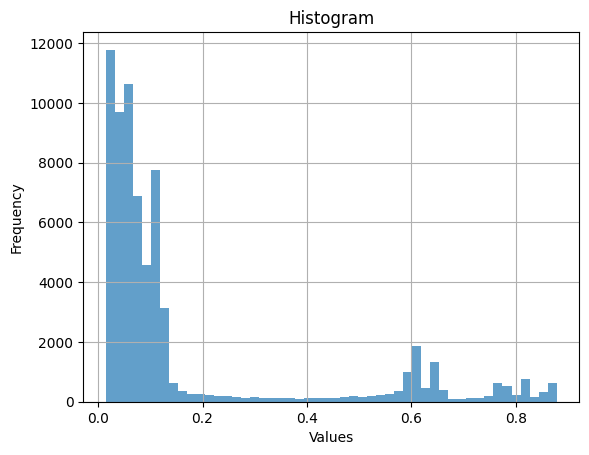

In [8]:
import matplotlib.pyplot as plt
# Plotting the histogram
probs = probs_test.cpu().detach().flatten()
plt.hist(probs, bins=50, alpha=0.7)
plt.title('Histogram')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()